# Effectiveness on Multiple Pooling
about pooling, then statistics, then pooling,

finally dataset used(short) and the experiments conducted and result found

In [2]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from typing import (List, Tuple)
from utils.plotting import HistoryPlotter

SEED = 42
BATCH_SIZE = 128
IMAGE_SIZE = [154,154]
DATASET_PATH = os.path.expanduser("~\Downloads\datasets\MaskedFaces")
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(SEED)

img_size = IMAGE_SIZE.copy()
img_size.append(3)
IMAGE_SIZE_3 = tuple(img_size)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Dataset Generation
About the dataset generation and why the old one was bad.

In [5]:
train_ds = keras.preprocessing.image_dataset_from_directory(DATASET_PATH,
                                                            validation_split=0.1,
                                                            subset="training",
                                                            seed=SEED,
                                                            image_size=IMAGE_SIZE,
                                                            batch_size=BATCH_SIZE, # def = 32
                                                            )
validation_ds = keras.preprocessing.image_dataset_from_directory(DATASET_PATH,
                                                            validation_split=0.1,
                                                            subset="validation",
                                                            seed=SEED,
                                                            image_size=IMAGE_SIZE,
                                                            batch_size=BATCH_SIZE,
                                                            )

train_ds = train_ds.prefetch(AUTOTUNE).cache()
# take 5 batches for test_ds, rest for validation_ds
test_ds = validation_ds.take(5).prefetch(AUTOTUNE).cache()
validation_ds = validation_ds.skip(5).prefetch(AUTOTUNE).cache()

Found 25673 files belonging to 2 classes.
Using 23106 files for training.
Found 25673 files belonging to 2 classes.
Using 2567 files for validation.


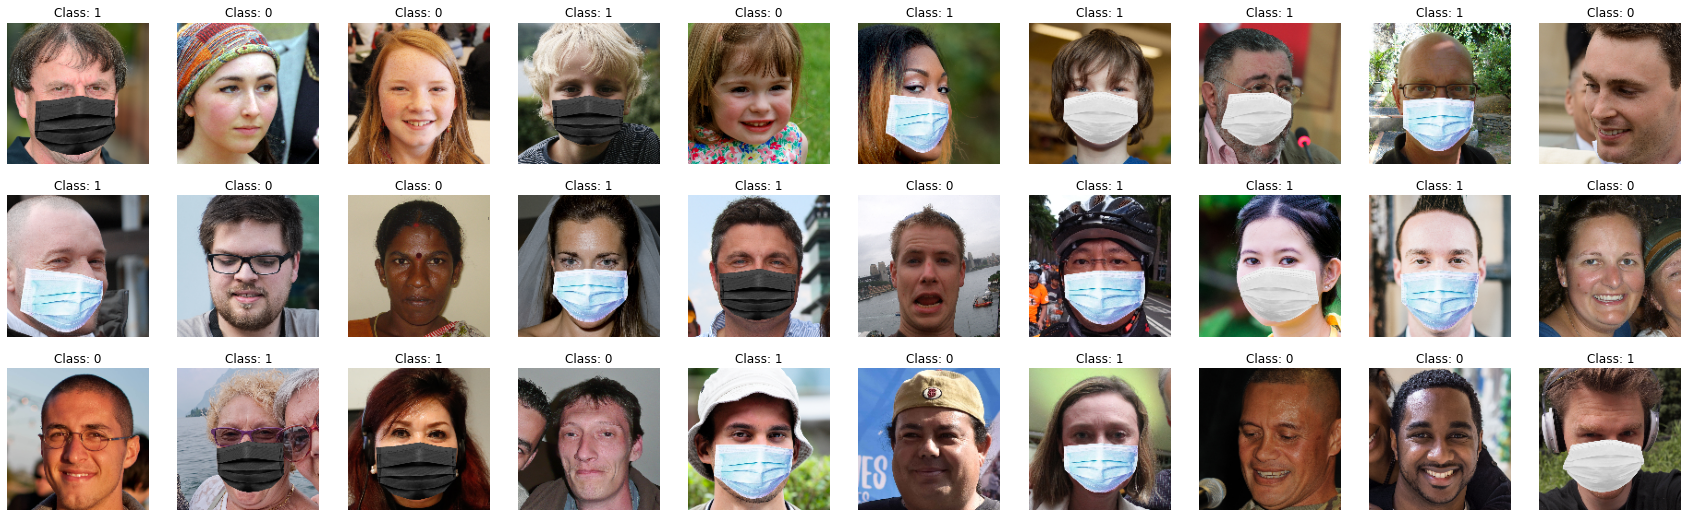

In [3]:
def plot_image(tfds_take, model=None, row_col: List[int]=[3,6]):
    """Plot image in a grid given a single batch of a tfds

    Args:
        tfds_take (tfds.take()): A single batch of tfds i.e., tfds.take(1)
        model (tf model, optional): Trained tensorflow mode, to predict the. Defaults to None.
        row_col (List[int], optional): Grid size. Defaults to [3,6].
    """
    fig = plt.figure(figsize=(row_col[1]*3, row_col[0]*3))
    
    for batch_img, batch_label in tfds_take:
        if model is not None:
            batch_pred = model.predict(batch_img)
            batch_pred = np.round(batch_pred, 2)

        for i in range(1, row_col[0]*row_col[1]+1): 
            ax = fig.add_subplot(row_col[0], row_col[1], i)
            
            ax.imshow(batch_img[i].numpy().astype("uint8"))
            ax.set_axis_off()

            if model is None:
                plt.title("Class: " + str(batch_label[i].numpy()))
            else:
                plt.title("True/Pred: " + str(batch_label[i].numpy()) + "/" + str(batch_pred[i][0]))
        # Process 1 batch alone if more is passed.
        break

plot_image(train_ds.take(1), row_col=[3,10])

# Baseline Model

In [14]:
baseline_model = keras.models.Sequential([
    # layer 1
    keras.layers.Conv2D(filters=32, kernel_size=8, strides=3, input_shape=IMAGE_SIZE_3, activation='relu'),
    keras.layers.MaxPool2D(pool_size=6, strides=3),

    # layer 2
    keras.layers.Conv2D(filters=64, kernel_size=4, activation='relu'),
    keras.layers.MaxPool2D(pool_size=4, strides=3),

    # layer 3
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),

    # layer 4
    keras.layers.Dense(units=64, activation='relu'),

    # layer 5
    keras.layers.Dense(units=1, activation='sigmoid')
])

In [15]:
def n_weights(model) -> Tuple[int,int]:
    """Return the number of total weights and trainable weights
    
    Args:
        model: Tensorflow model
    Returns:
        Tuple[int, int]: Returns the total_weights and trainable_weights
    """
    n_total = 0
    n_train = 0
    for weight in model.weights:
        n_total += weights_from_shape(weight.shape)
        
    for weight in model.trainable_weights:
        n_train += weights_from_shape(weight.shape)
    
    return n_total, n_train

def weights_from_shape(shape) -> int:
    """Compute the total number of weights given the shape of the tensor.
    """
    weights = 1
    for dim in shape:
        weights *= int(dim)
    return weights

total_weights, train_weights = n_weights(baseline_model)
print(f"Total weights/parameters: {total_weights}\nTrainable weights/parameters: {train_weights}")

Total weights/parameters: 121185
Trainable weights/parameters: 121185


In [16]:
baseline_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    metrics=[   
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ]
)
baseline_history = baseline_model.fit(train_ds, epochs=15, validation_data=validation_ds)

Epoch 1/15
181/181 [==============================] - 4s 15ms/step - loss: 2.9092 - binary_accuracy: 0.6547 - precision_4: 0.6513 - recall_4: 0.8510 - val_loss: 0.5699 - val_binary_accuracy: 0.6554 - val_precision_4: 0.6338 - val_recall_4: 0.9189
Epoch 2/15
181/181 [==============================] - 2s 13ms/step - loss: 0.4019 - binary_accuracy: 0.8135 - precision_4: 0.7984 - recall_4: 0.9010 - val_loss: 0.2174 - val_binary_accuracy: 0.9185 - val_precision_4: 0.9487 - val_recall_4: 0.9041
Epoch 3/15
181/181 [==============================] - 2s 13ms/step - loss: 0.1683 - binary_accuracy: 0.9456 - precision_4: 0.9492 - recall_4: 0.9559 - val_loss: 0.0446 - val_binary_accuracy: 0.9886 - val_precision_4: 0.9935 - val_recall_4: 0.9862
Epoch 4/15
181/181 [==============================] - 2s 13ms/step - loss: 0.0420 - binary_accuracy: 0.9865 - precision_4: 0.9863 - recall_4: 0.9902 - val_loss: 0.0236 - val_binary_accuracy: 0.9933 - val_precision_4: 0.9954 - val_recall_4: 0.9926
Epoch 5/15
1

KeyboardInterrupt: 

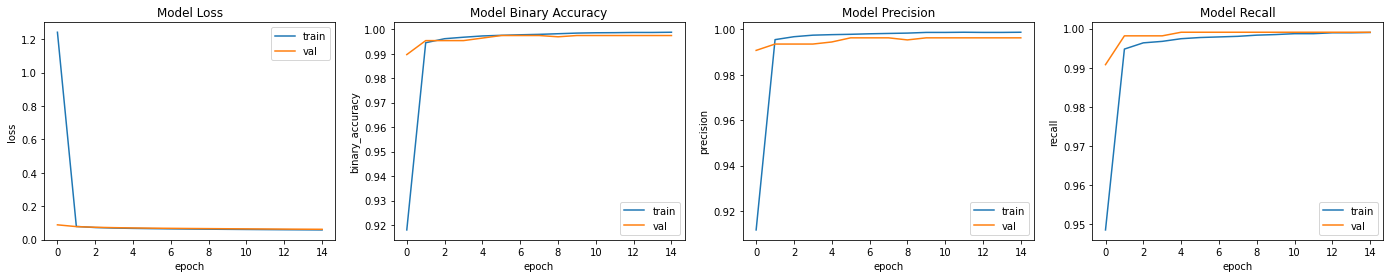

In [7]:
np.save("./models/baseline_history.npy", baseline_history.history)
# baseline_history = np.load("./models/baseline_history.npy", allow_pickle='TRUE').item()
baseline_plot = HistoryPlotter(history=baseline_history.history)
baseline_plot.all(row_col=[1,0])

In [ ]:
n_rows = 3
n_cols = 6
fig = plt.figure(figsize=(n_cols*3, n_rows*3))
    
for batch_img, batch_label in test_ds.take(1):
    batch_pred = baseline_model.predict(batch_img)
    batch_pred = np.round(batch_pred, 2)

    for i in range(1, n_rows*n_cols+1): 
        ax = fig.add_subplot(n_rows, n_cols, i)
        ax.imshow(batch_img[i].numpy().astype("uint8"))

        plt.title("True/Pred = " + str(batch_label[i].numpy()) + "/" + str(batch_pred[i][0]))
        ax.set_axis_off()
    

In [8]:
optimal_pooling = keras.models.Sequential([
    # layer 1
    keras.layers.Conv2D(filters=32, kernel_size=8, strides=3, kernel_regularizer=keras.regularizers.l2(), input_shape=IMAGE_SIZE_3),
    keras.layers.MaxPool2D(pool_size=6, strides=3),
    keras.layers.Activation('relu'),

    # layer 2
    keras.layers.Conv2D(filters=64, kernel_size=4),
    keras.layers.MaxPool2D(pool_size=4, strides=3),
    keras.layers.Activation('relu'),

    # layer 3
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),

    # layer 4
    keras.layers.Dense(units=64, activation='relu'),

    # layer 5
    keras.layers.Dense(units=1, activation='sigmoid')
])

In [10]:
optimal_pooling.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    metrics=[   
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ]
)
optimal_pooling_history = optimal_pooling.fit(train_ds, epochs=15, validation_data=validation_ds)

Epoch 1/15
181/181 [==============================] - 3s 13ms/step - loss: 0.2149 - binary_accuracy: 0.9478 - precision_2: 0.9499 - recall_2: 0.9591 - val_loss: 0.1429 - val_binary_accuracy: 0.9735 - val_precision_2: 0.9761 - val_recall_2: 0.9770
Epoch 2/15
181/181 [==============================] - 2s 11ms/step - loss: 0.1372 - binary_accuracy: 0.9747 - precision_2: 0.9747 - recall_2: 0.9811 - val_loss: 0.1018 - val_binary_accuracy: 0.9855 - val_precision_2: 0.9880 - val_recall_2: 0.9862
Epoch 3/15
181/181 [==============================] - 2s 11ms/step - loss: 0.1744 - binary_accuracy: 0.9628 - precision_2: 0.9683 - recall_2: 0.9664 - val_loss: 0.0912 - val_binary_accuracy: 0.9870 - val_precision_2: 0.9917 - val_recall_2: 0.9853
Epoch 4/15
181/181 [==============================] - 2s 11ms/step - loss: 0.0918 - binary_accuracy: 0.9898 - precision_2: 0.9893 - recall_2: 0.9930 - val_loss: 0.0805 - val_binary_accuracy: 0.9912 - val_precision_2: 0.9926 - val_recall_2: 0.9917
Epoch 5/15
1

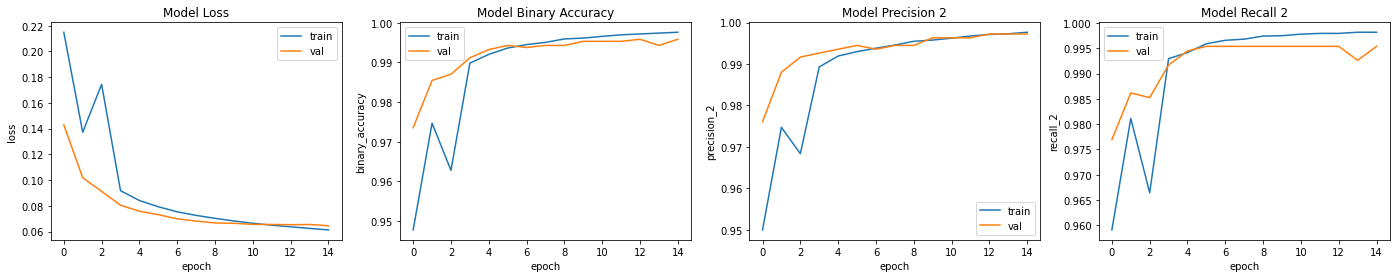

In [11]:
np.save("./models/optimal_pooling_history.npy", optimal_pooling_history.history)
# baseline_history = np.load("./models/baseline_history.npy", allow_pickle='TRUE').item()
optimal_pooling_plot = HistoryPlotter(history=optimal_pooling_history.history)
optimal_pooling_plot.all(row_col=[1,0])

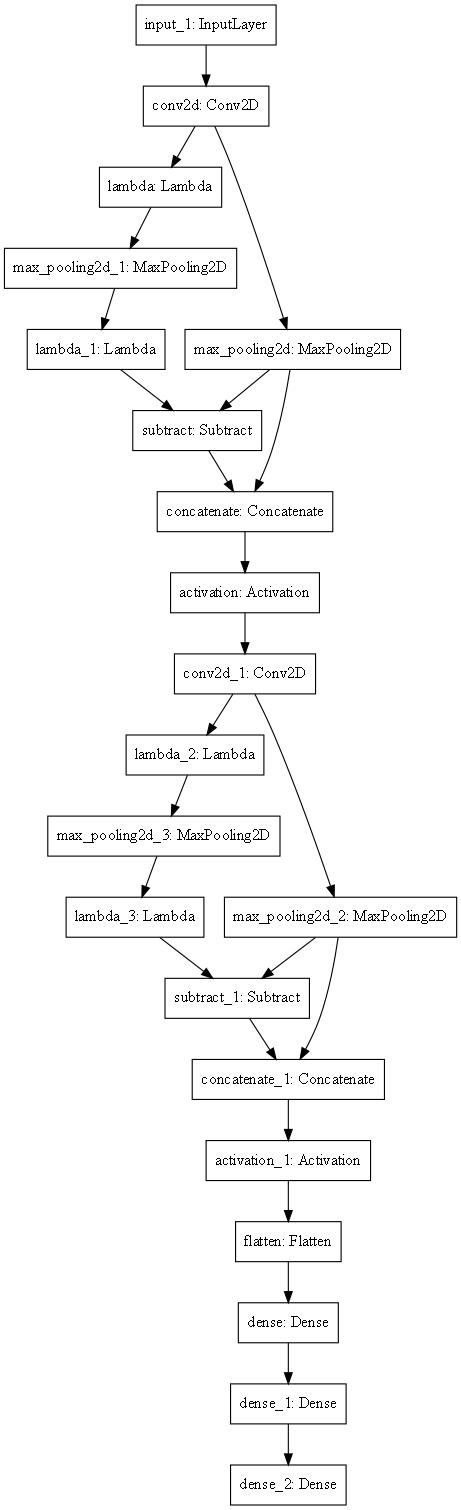

In [3]:
def get_multiple_pooling_model():
    inputs = keras.layers.Input(shape=IMAGE_SIZE_3)
    l1 = keras.layers.Conv2D(filters=32, kernel_size=8, strides=3, kernel_regularizer=keras.regularizers.l2(), input_shape=IMAGE_SIZE_3)(inputs)
    
    l1_max = keras.layers.MaxPool2D(pool_size=6, strides=3)(l1)
    # 1. negative of feature map
    l1_min = keras.layers.Lambda(lambda x: tf.math.negative(x))(l1) 
    # l1_min = tf.math.negative(l1) # does not work as a tensor, instead need to apply it as a layer using lambda.
   
    # 2. apply maxpool to get min statistics
    l1_min = keras.layers.MaxPool2D(pool_size=6, strides=3)(l1_min)
    
    # 3. Revert to original after getting min statistics
    l1_min = keras.layers.Lambda(lambda x: tf.math.negative(x))(l1_min)
    # l1_min = tf.math.negative(l1_min)
   
    # 4. get range statistic max - min
    l1_range = keras.layers.subtract([l1_max, l1_min])
    # l1_range = tf.math.subtract(l1_max, l1_min)
    
    # 5. Concatenate to get multiple pooling
    l1_multi_pool = keras.layers.Concatenate()([l1_max, l1_range]) # num of channels = 2x baseline = 64
    l1_multi_pool = keras.layers.Activation('relu')(l1_multi_pool) 

    l2 = keras.layers.Conv2D(filters=32, kernel_size=4)(l1_multi_pool) # reduce filter to 32 to make it similar to baseline
    
    l2_max = keras.layers.MaxPool2D(pool_size=4, strides=3)(l2) 
    l2_min = keras.layers.Lambda(lambda x: tf.math.negative(x))(l2)
    # l2_min = tf.math.negative(l2)
    l2_min = keras.layers.MaxPool2D(pool_size=4, strides=3)(l2_min)
    l2_min = keras.layers.Lambda(lambda x: tf.math.negative(x))(l2_min)
    # l2_min = tf.math.negative(l2_min)
    l2_range = tf.keras.layers.subtract([l2_max, l2_min])
    # l2_range = tf.math.subtract(l2_max, l2_min)
    l2_multi_pool = keras.layers.Concatenate()([l2_max, l2_range])
    l2_multi_pool = keras.layers.Activation('relu')(l2_multi_pool)

    l3 = keras.layers.Flatten()(l2_multi_pool)
    l3 = keras.layers.Dense(units=128, activation='relu')(l3)
    l4 = keras.layers.Dense(units=64, activation='relu')(l3)
    l5 = keras.layers.Dense(units=1, activation='sigmoid')(l4)

    model = keras.models.Model(inputs=inputs, outputs=l5)
    return model

multiple_pooling = get_multiple_pooling_model()
tf.keras.utils.plot_model(multiple_pooling, 
                          show_shapes=False, 
                          dpi=80)

In [6]:
multiple_pooling.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    metrics=[   
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ]
)
multiple_pooling_history = multiple_pooling.fit(train_ds, epochs=15, validation_data=validation_ds)

Epoch 1/15
181/181 [==============================] - 273s 2s/step - loss: 2.9406 - binary_accuracy: 0.8718 - precision_1: 0.8901 - recall_1: 0.8848 - val_loss: 0.1271 - val_binary_accuracy: 0.9751 - val_precision_1: 0.9924 - val_recall_1: 0.9631
Epoch 2/15
181/181 [==============================] - 3s 14ms/step - loss: 0.0984 - binary_accuracy: 0.9848 - precision_1: 0.9890 - recall_1: 0.9842 - val_loss: 0.0901 - val_binary_accuracy: 0.9881 - val_precision_1: 0.9963 - val_recall_1: 0.9825
Epoch 3/15
181/181 [==============================] - 2s 14ms/step - loss: 0.0764 - binary_accuracy: 0.9925 - precision_1: 0.9954 - recall_1: 0.9915 - val_loss: 0.0785 - val_binary_accuracy: 0.9912 - val_precision_1: 0.9972 - val_recall_1: 0.9871
Epoch 4/15
181/181 [==============================] - 2s 13ms/step - loss: 0.0682 - binary_accuracy: 0.9953 - precision_1: 0.9968 - recall_1: 0.9949 - val_loss: 0.0717 - val_binary_accuracy: 0.9933 - val_precision_1: 0.9981 - val_recall_1: 0.9899
Epoch 5/15
1

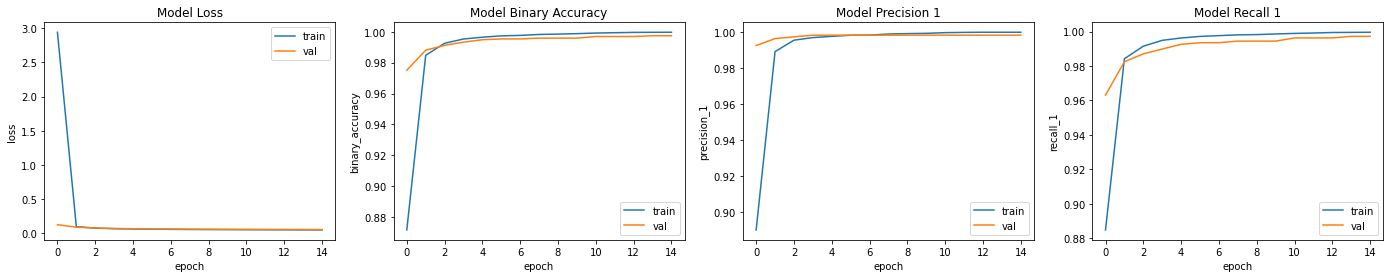

In [7]:
np.save("./models/multiple_pooling_history.npy", multiple_pooling_history.history)
# baseline_history = np.load("./models/baseline_history.npy", allow_pickle='TRUE').item()
multiple_pooling_plot = HistoryPlotter(history=multiple_pooling_history.history)
multiple_pooling_plot.all(row_col=[1,0])